# Vortex panel method
Historically, the first panel method ever developed was a source-sheet method. At the time, Douglas Aircraft Company was concerned with calculating the flow around bodies of revolution, and it was only later that the method was extended to lifting surfaces. (See the reference below for a nice historical account.)

A *source-panel method* leads to a solution with no circulation, therefore no lift. The objective of this lesson is to start with the source panel method we implemented in the previous lesson and add some *circulation* so that we may have a lift force. We introduce an important concept: the **Kutta-condition** that allows us to determine what the right amount of circulation should be.
##### Reference

* Smith, A.M.O., The Panel Method: Its Original Development. In _Applied Computational Aerodynamics_, Vol. 125, edited by P.A. Henne, published by AIAA (1990). [Read it on Google Books.](http://books.google.com/books?id=5Ov2tHj0wxoC&lpg=PA3&ots=SnUiqcdEnb&dq=The%20Panel%20Method%3A%20Its%20Original%20Development&pg=PA3#v=onepage&q&f=false)

## A lifting-body panel method
If we were to simply increase the angle of attack in the freestream and calculate the flow with a source sheet only, the rear stagnation point will not be located at the trailing edge. Instead, the flow will bend around the trailing edge and the stagnation point will be somewhere on the top surface of the airfoil. This is not a physically possible solution.

### The Kutta condition

The *Kutta-condition* states that the pressure below and above the airfoil trailing edge must be equal so that the flow does not bend around it and instead leaves the airfoil tangentially. The rear stagnation point must be exactly at the trailing edge.

It's natural to be a little perplexed by this. How can we justify this seemingly arbitrary condition? Remember that potential-flow theory completely ignores fluid viscosity, so if we are leaving out this physical effect, we shouldn't be surprised that the theory needs some adjustment for those situations when viscosity does play a role. A real viscous fluid is not able to turn around a sharp corner like an airfoil trailing edge without separating there. The Kutta condition allows us to correct potential-flow theory so that it gives a solution closer to reality.

Remember **lift always requires circulation**. If you experimented with the circulation of the point vortex, you found that the stagnation points moved along the cylinder.

Like for the circular cylinder, the amount of circulation we add to an airfoil will move the stagnation points along the surface. And if we add just the right amount, the rear stagnation point can be made to coincide with the trailing edge. This amount of circulation makes the flow a physically relevant solution. And this amount gives the correct lift!

To implement the Kutta-condition in our panel method we need to add one more equation to the system, giving the circulation that moves the stagnation point to the trailing edge. By placing a vortex-sheet with the same constant strength at every panel, we can add the circulation to the flow with just one more unknown.


### Discretization into panels
Let's get the preliminaries out of the way. We need to import our favorite libraries, and the function `integrate` from SciPy.

In [2]:
# import libraries and modules needed
import os
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot

# integrate plots into the notebook
%matplotlib inline

We start by importing the NACA0012 geometry from a data file, and we plot the airfoil:

In [3]:
# load geometry from data file
naca_filepath ='naca0012.dat'
with open(naca_filepath, 'r') as infile:
    x, y = numpy.loadtxt(infile, dtype=float, unpack=True)

(-0.05, 1.05, -0.06601892, 0.06601892)

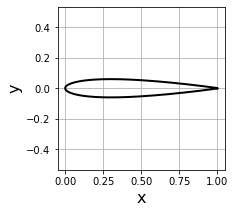

In [10]:
# plot geometry
width = 3
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1)
pyplot.axis('equal')

The contour defining the airfoil will be partitioned into `N` panels.

We define a class `Panel`  that will store all information about one panel: start and end points, center point, length, orientation, source strength, tangential velocity and pressure coefficient. We don't save the vortex-sheet strength because all panels will have the same value.

In [11]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the circulation, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.gamma = 0.0  # circulation strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

Like before, we call the function `define_panels` to discretize the airfoil geometry in `N` panels. The function will return a NumPy array of `N` objects of the type `Panel`.

In [12]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects.
        The list of panels.
    """
    
    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    
    theta = numpy.linspace(0.0, 2.0 * numpy.pi, N + 1)  # array of angles
    x_circle = x_center + R * numpy.cos(theta)  # x-coordinates of circle
    
    x_ends = numpy.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = numpy.empty_like(x_ends)  # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

Now we can use our new function to define the geometry for the airfoil panels, and then plot the panel nodes on the geometry.

In [13]:
# discretize geoemetry into panels
panels = define_panels(x, y, N=40)

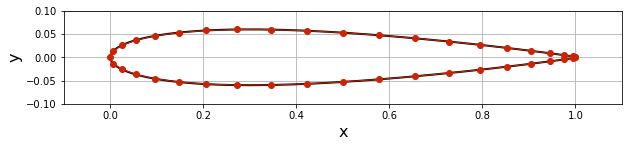

In [16]:
# plot discretized geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

### Free stream conditions

The airfoil is immersed in a free-stream $(U_\infty$,$\alpha)$ where $U_\infty$ and $\alpha$ are the velocity magnitude and angle of attack, respectively. Like before, we create a class for the free stream, even though we will only have one object that uses this class. It makes it easier to pass the free stream to other functions later on.

In [17]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians

In [18]:
# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=4.0)

### Flow tangency boundary condition

A constant vortex strength $\gamma$ will be added to each panel (all panels have the same, constant vortex-sheet strength). Thus, using the principle of superposition, the velocity potential becomes:

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha \\
&+ \sum_{j=1}^N \frac{\sigma_j}{2\pi} \int_j \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1}^N \frac{\gamma}{2\pi} \int_j \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

The flow tangency boundary condition is applied at every panel center:

$$0 = \vec{V}\cdot\vec{n}_i = \frac{\partial}{\partial n_i} \left\{ \phi\left(x_{c_i},y_{c_i}\right) \right\}$$

i.e.

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

We already worked the first integral in the previous lesson:

$$\frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) = \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$, and

$$x_j(s_j) = x_{b_j} - s_j \sin \beta_j$$

$$y_j(s_j) = y_{b_j} + s_j \cos \beta_j$$

We now need to derive the last integral of the boundary equation:

$$\frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right)= \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$.